In [ ]:
from skimage.io import imread
from skimage import measure
import numpy as np
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, LineString, Point
from skimage.transform import PiecewiseAffineTransform, warp

In [ ]:
def get_contour_coords(single_plane: np.ndarray, label_id: int) -> List[Tuple[int, int]]:
    x_dim, y_dim = single_plane.shape
    tmp_array = np.zeros((x_dim, y_dim), dtype='uint8')
    tmp_array[np.where(single_plane == label_id)] = 1
    tmp_contours = measure.find_contours(tmp_array, level = 0)[0]
    return tmp_contours

In [ ]:
def get_intersection_point_coords(line_a_point_idxs: Tuple[int, int], line_b_point_idxs: Tuple[int, int], 
                                  contour_coords: List[Tuple[int, int]], polygon: Polygon) -> Optional[Tuple[float, float]]:
    line_a = LineString([contour_coords[line_a_point_idxs[0]], contour_coords[line_a_point_idxs[1]]])
    line_b = LineString([contour_coords[line_b_point_idxs[0]], contour_coords[line_b_point_idxs[1]]])
    if line_a.intersects(line_b):
        intersection_point = line_a.intersection(line_b)
        if (type(intersection_point) == Point) & (polygon.contains(intersection_point)):
            return intersection_point.x, intersection_point.y

In [ ]:
def rearrange_array_to_begin_with_reference_point(unsorted_contour_coords: np.ndarray, reference_point_idx: int) -> np.ndarray:
    return np.concatenate([unsorted_contour_coords[reference_point_idx:], unsorted_contour_coords[:reference_point_idx]])

In [ ]:
def plot_query_and_reference_images_with_points(query_img: np.ndarray, query_points: np.ndarray,
                                                reference_img: np.ndarray, reference_points: np.ndarray) -> None:
    fig = plt.figure(figsize=(10, 5), facecolor='white')
    gs = fig.add_gridspec(1, 2)
    
    ax1 = fig.add_subplot(gs[0, 0])
    plt.imshow(query_img, cmap='Greys')
    plt.scatter(query_points[:, 1], query_points[:, 0], s=30, c=range(query_points.shape[0]), cmap='viridis')
    plt.title('query')
    ax2 = fig.add_subplot(gs[0, 1])
    plt.imshow(reference_img, cmap='Greys')
    plt.scatter(reference_points[:, 1], reference_points[:, 0], s=30, c=range(query_points.shape[0]), cmap='viridis')
    plt.title('reference')
    plt.show()

In [ ]:
def plot_query_transformed_and_reference_images_with_points(query_img: np.ndarray, query_points: np.ndarray,
                                                            transformed_img: np.ndarray, transformed_points: np.ndarray,
                                                            reference_img: np.ndarray, reference_points: np.ndarray) -> None:
    fig = plt.figure(figsize=(15, 5), facecolor='white')
    gs = fig.add_gridspec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    plt.imshow(query_img, cmap='Greys')
    plt.scatter(query_points[:, 1], query_points[:, 0], s=30, c=range(query_points.shape[0]), cmap='viridis')
    plt.title('query')
    ax2 = fig.add_subplot(gs[0, 1])
    plt.imshow(transformed_img, cmap='Greys')
    plt.scatter(transformed_points[:, 1], transformed_points[:, 0], s=30, c=range(query_points.shape[0]), cmap='viridis')
    plt.title('transformed')
    ax3 = fig.add_subplot(gs[0, 2])
    plt.imshow(reference_img, cmap='Greys')
    plt.scatter(reference_points[:, 1], reference_points[:, 0], s=30, c=range(query_points.shape[0]), cmap='viridis')
    plt.title('reference')
    plt.show()

In [ ]:
def sample_contour_points(contour_coords: np.ndarray, n_points_to_sample: int) -> np.ndarray:
    return np.linspace(0, contour_coords.shape[0], n_points_to_sample, endpoint=False, dtype=int)

In [ ]:
def get_matches_intersection_point_coords(query_contour_coords: np.ndarray, query_polygon,
                                          reference_contour_coords: np.ndarray, reference_polygon,
                                          target_n_matches: int, max_attempts: int=1000) -> Dict[str, List[np.ndarray]]:
    assert query_contour_coords.shape[0] == reference_contour_coords.shape[0], 'numbers of sampled coords are not identical!'
    matched_intersection_point_coords = {'query': [],
                                         'reference': []}
    sample_idxs = np.arange(0, query_contour_coords.shape[0], 1)
    for i in range(max_attempts):
        four_point_idxs = np.random.choice(sample_idxs, 4, replace=False)
        query_intersection_coords = get_intersection_point_coords(four_point_idxs[:2], four_point_idxs[2:], query_contour_coords, query_polygon)
        reference_intersection_coords = get_intersection_point_coords(four_point_idxs[:2], four_point_idxs[2:], reference_contour_coords, reference_polygon)
        if (query_intersection_coords != None) & (reference_intersection_coords != None):
            matched_intersection_point_coords['query'].append(query_intersection_coords)
            matched_intersection_point_coords['reference'].append(reference_intersection_coords)
        if len(matched_intersection_point_coords['query']) == target_n_matches:
            print(f'{target_n_matches} matching intersection points found!')
            break
    return matched_intersection_point_coords

In [ ]:
def crop_image_and_adjust_point_coords(image: np.ndarray, points_coords: np.ndarray, polygon: Polygon, box_shape: Tuple[int, int]) -> Tuple[np.ndarray, np.ndarray]:
    centroid_row, centroid_col = int(polygon.centroid.x), int(polygon.centroid.y)
    row_min, row_max = centroid_row - box_shape[0], centroid_row + box_shape[0] # pad with black pixels if otherwise too small!
    col_min, col_max = centroid_col - box_shape[1], centroid_col + box_shape[1] # pad with black pixels if otherwise too small!
    cropped_image = image[row_min:row_max, col_min:col_max].copy()
    offset_adjusted_points_coords = np.asarray([(coords[0] - row_min, coords[1] - col_min) for coords in points_coords])
    return cropped_image, offset_adjusted_points_coords

In [ ]:
def convert_coordinates_to_col_row_format(array: np.ndarray) -> np.ndarray:
    converted_array = np.zeros_like(array)
    converted_array[:, 0] = array[:, 1].copy()
    converted_array[:, 1] = array[:, 0].copy()
    return converted_array

In [ ]:
def transform_new_query_points(query_coords: np.ndarray, estimated_transformation: PiecewiseAffineTransform) -> np.ndarray:
    query_coords_col_row_format = convert_coordinates_to_col_row_format(query_coords)
    transformed_query_coords_col_row_format = estimated_transformation.inverse(query_coords_col_row_format)
    return convert_coordinates_to_col_row_format(transformed_query_coords_col_row_format)

In [ ]:
query = imread('test_data/polygon.png')
query_contours = get_contour_coords(query, 255) # will start per default with lowest left point (= max for both coords)
query_polygon = Polygon(query_contours)

In [ ]:
reference = imread('test_data/rotated_square.png')
reference_contours = get_contour_coords(reference, 255)
reference_polygon = Polygon(reference_contours)

In [ ]:
# for the irregular shape:

# upper most contour pixel in query matches left most in reference:
query_anker_point_idx = query_contours[:, 0].argmin()

# left most contour pixel in reference matches upper most in query:
reference_anker_point_idx = reference_contours[:, 1].argmin()

In [ ]:
# for squares: (matches by accident)
query_anker_point_idx = 0
reference_anker_point_idx = 0

In [ ]:
# for polygon as query and square as reference:
query_anker_point_idx = 355
reference_anker_point_idx = 0

In [ ]:
sorted_query_contours = rearrange_array_to_begin_with_reference_point(query_contours, query_anker_point_idx)
sorted_reference_contours = rearrange_array_to_begin_with_reference_point(reference_contours, reference_anker_point_idx)

In [ ]:
query_contour_sample_idxs = sample_contour_points(sorted_query_contours, 100)
query_sampled_contour_coords = sorted_query_contours[query_contour_sample_idxs]

reference_contour_sample_idxs = sample_contour_points(sorted_reference_contours, 100)
reference_sampled_contour_coords = sorted_reference_contours[reference_contour_sample_idxs]

In [ ]:
matched_intersection_point_coords = get_matches_intersection_point_coords(query_sampled_contour_coords, query_polygon,
                                                                          reference_sampled_contour_coords, reference_polygon,
                                                                          target_n_matches = 500)

In [ ]:
test_matches = get_matches_intersection_point_coords(query_sampled_contour_coords, query_polygon,
                                                      reference_sampled_contour_coords, reference_polygon,
                                                      target_n_matches = 100)

100 matching intersection points found!


In [ ]:
query_matched_point_coords = np.concatenate([query_sampled_contour_coords, matched_intersection_point_coords['query']])
reference_matched_point_coords = np.concatenate([reference_sampled_contour_coords, matched_intersection_point_coords['reference']])

In [ ]:
query_test_matched_point_coords = np.asarray(test_matches['query'])
reference_test_matched_point_coords = np.asarray(test_matches['reference'])

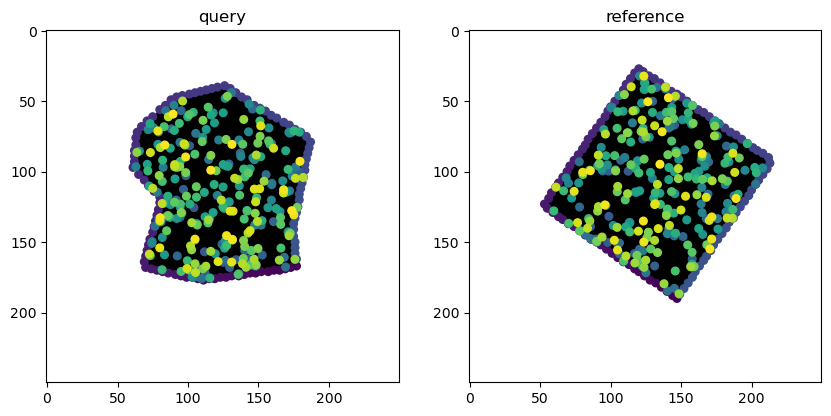

In [ ]:
plot_query_and_reference_images_with_points(query, query_matched_point_coords,
                                            reference, reference_matched_point_coords)

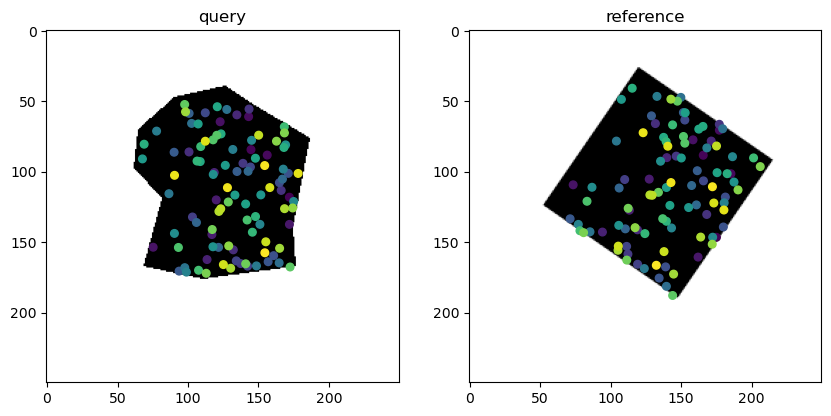

In [ ]:
plot_query_and_reference_images_with_points(query, query_test_matched_point_coords,
                                            reference, reference_test_matched_point_coords)

In [ ]:
query_box_coords = [int(idx) for idx in query_polygon.bounds]
reference_box_coords = [int(idx) for idx in reference_polygon.bounds]
half_width_rows = max([query_box_coords[2] - query_box_coords[0], reference_box_coords[2] - reference_box_coords[0]]) // 2
half_width_cols = max([query_box_coords[3] - query_box_coords[1], reference_box_coords[3] - reference_box_coords[1]]) // 2
box_shape = (half_width_rows, half_width_cols)

In [ ]:
query_centroid, query_centroid_coords = crop_image_and_adjust_point_coords(query, query_matched_point_coords, query_polygon, box_shape)
reference_centroid, reference_centroid_coords = crop_image_and_adjust_point_coords(reference, reference_matched_point_coords, reference_polygon, box_shape)

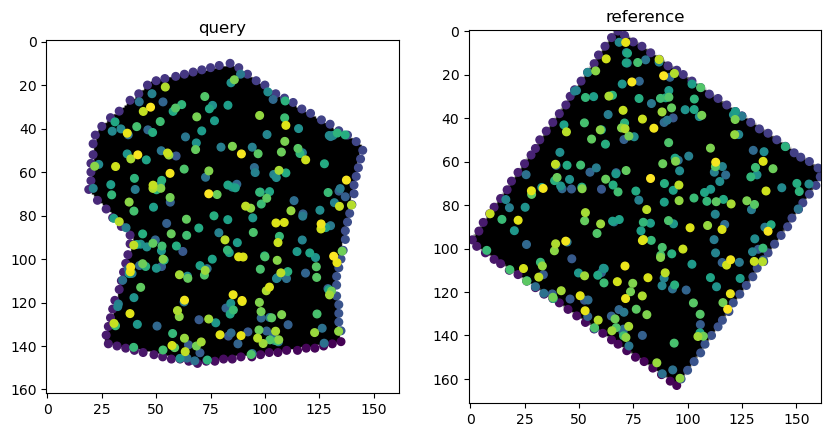

In [ ]:
plot_query_and_reference_images_with_points(query_centroid, query_centroid_coords,
                                            reference_centroid, reference_centroid_coords)

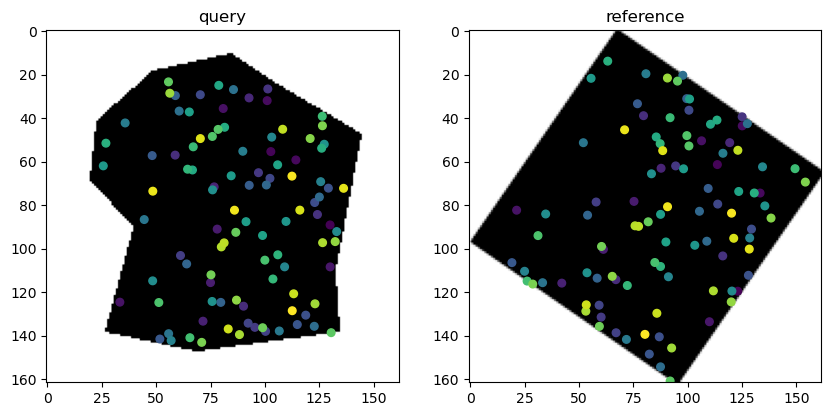

In [ ]:
_, query_test_centroid_coords = crop_image_and_adjust_point_coords(query, query_test_matched_point_coords, query_polygon, box_shape)
_, reference_test_centroid_coords = crop_image_and_adjust_point_coords(reference, reference_test_matched_point_coords, reference_polygon, box_shape)
plot_query_and_reference_images_with_points(query_centroid, query_test_centroid_coords,
                                            reference_centroid, reference_test_centroid_coords)

In [ ]:
query_centroid_coords_for_transform_estimation = convert_coordinates_to_col_row_format(query_centroid_coords)
reference_centroid_coords_for_transform_estimation = convert_coordinates_to_col_row_format(reference_centroid_coords)

In [ ]:
tform = PiecewiseAffineTransform()
tform.estimate(reference_centroid_coords_for_transform_estimation, query_centroid_coords_for_transform_estimation)

/tmp/ipykernel_833/2765498448.py:2: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  tform.estimate(reference_centroid_coords_for_transform_estimation, query_centroid_coords_for_transform_estimation)


True

<matplotlib.image.AxesImage>

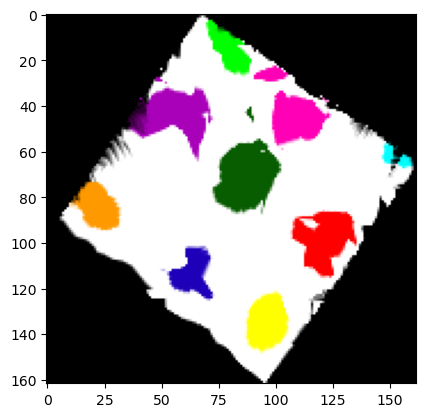

In [ ]:
test_img = imread('test_data/colored_polygon.png')
test_centroid, _ = crop_image_and_adjust_point_coords(test_img, query_matched_point_coords, query_polygon, box_shape)
out_rows, out_cols = reference_centroid.shape
out = warp(test_centroid, tform) 
# seems like rows and columns are switched up for the image!
# for instance, compare the difference between the .plot and the .scatter method:
# ax.scatter(tform.inverse(query_centroid_coords)[:, 0], tform.inverse(query_centroid_coords)[:, 1])
# ax.plot(tform.inverse(query_centroid_coords)[:, 0], tform.inverse(query_centroid_coords)[:, 1], '.b')
plt.imshow(out)

In [ ]:
transformed_query_points = transform_new_query_points(query_centroid_coords, tform)
transformed_query_test_points = transform_new_query_points(query_test_centroid_coords, tform)

/tmp/ipykernel_833/1425468815.py:3: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  transformed_query_coords_col_row_format = estimated_transformation.inverse(query_coords_col_row_format)


<matplotlib.image.AxesImage>

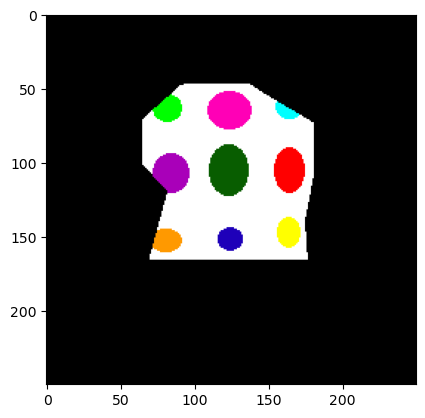

In [ ]:
plt.imshow(test_img)

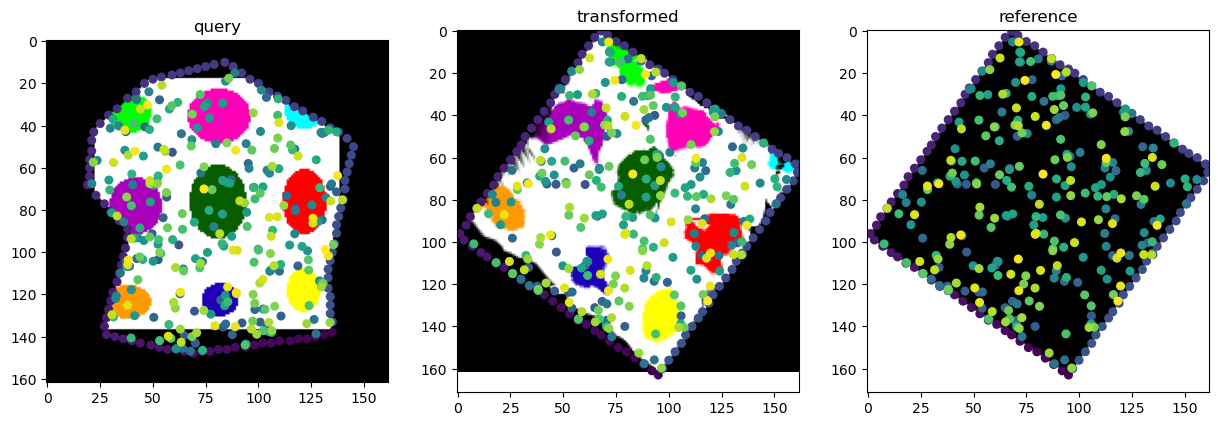

In [ ]:
plot_query_transformed_and_reference_images_with_points(test_centroid, query_centroid_coords,
                                                        out, transformed_query_points,
                                                        reference_centroid, reference_centroid_coords)

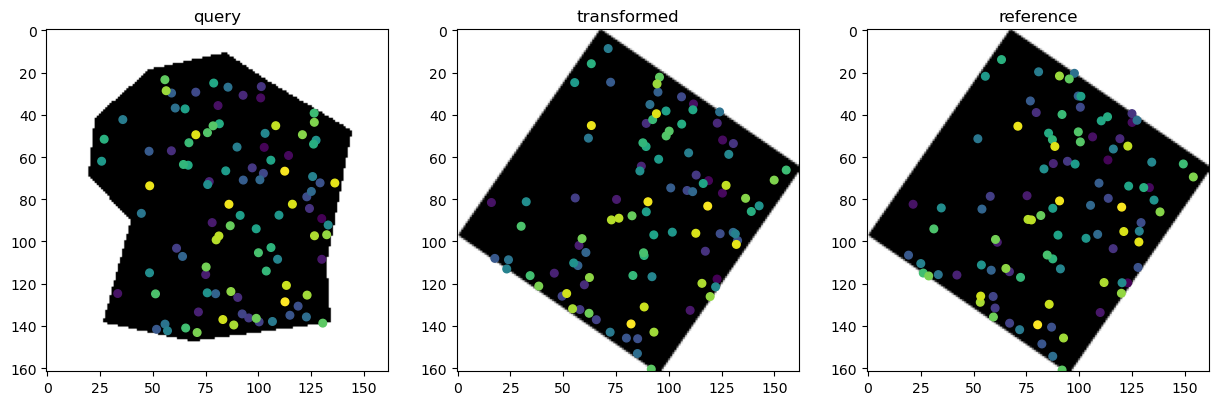

In [ ]:
plot_query_transformed_and_reference_images_with_points(query_centroid, query_test_centroid_coords,
                                                        reference_centroid, transformed_query_test_points,
                                                        reference_centroid, reference_test_centroid_coords)

This would give us the option to always have a quality estimate (using a set of test points as shown above